# Salary predicts Based on Job Discriptions

## Part 1: Defining the problem

Peredicting salary for the upcoming jobs, based on their discriptions with reliable accuracy

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import scipy.stats as sp
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score as cvs
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
#your info here
__author__ = "Salman Panahy"
__email__ = "salman.panahi@gmail.com"

## Part 2: Discover

### 2-1 Loading Data and First Inspection

In [2]:
#loading the data into a Pandas dataframe
train_features = pd.read_csv('train_features.csv')
train_target = pd.read_csv('train_salaries.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
#Data at first glance
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [19]:
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [4]:
train_target.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
#checking the size of data
train_features.shape

(1000000, 8)

In [20]:
test_features.shape

(1000000, 8)

In [6]:
train_target.shape

(1000000, 2)

In [7]:
#checking if there is any duplicated Job Id
train_features['jobId'].is_unique

True

In [21]:
test_features['jobId'].is_unique

True

In [3]:
#merging train data sets
train_df=pd.merge(train_features, train_target, on='jobId')
train_df.shape

(1000000, 9)

### 2-2 Cleaning Data

In [9]:
# Checking if there is missing data
train_df.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [23]:
test_features.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [10]:
# Checking data type
train_df.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [24]:
test_features.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [4]:
#casting type to categorical data
train_df[['companyId','jobType','major','degree','industry']]=train_df[['companyId',
    'jobType','major','degree','industry']].astype('category')
test_features[['companyId','jobType','major','degree','industry']]=test_features[['companyId',
    'jobType','major','degree','industry']].astype('category')
train_df.dtypes

jobId                    object
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

We have already checked and know that all job Ids are unique, however we can check if there are some jobs exactly the same besides their Id.

In [12]:
#checking for identical rows, regardless of jobId
train_df[['companyId','jobType','degree','major','industry',
                   'yearsExperience','milesFromMetropolis','salary']].duplicated().sum()

186

We also can check if there are some jobs with exactly the same discription, but different salayies.

In [13]:
#checking for identical rows, regardless of jobId and salary
train_df[['companyId','jobType','degree','major','industry',
                   'yearsExperience','milesFromMetropolis']].duplicated().sum()

8001

This shows that there are some jobs with exactly the same descriptions from the same companies, but different salaries. As they have different job Ids, we are going to let these stay in our dataset. Despite the fact that having different target values for the same features is going to have a negative effect on our predictions, keeping data as it is would help to capture the nature of the data. 

In [14]:
#checking for invalid salary values
(train_df['salary']<=0).any()

True

In [15]:
#checking for the number of invalid salary values
(train_df['salary']<=0).sum()

5

In [5]:
#dropping invalid salary values
train_df.drop(train_df[train_df.salary <=0].index, inplace=True)

### 2-3  Exploratory Data Analysis (EDA)

#### 2-3-1 Summarizing each variable

In [17]:
#general view of data
train_df.describe(include= 'all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,999995,999995,999995,999995,999995,999995,999995.000000,999995.000000,999995.000000
unique,999995,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362684613849,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236975,532353,143205,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992407,49.529381,116.062398
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212390,28.877721,38.717163
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,17.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


#### 2-3-2 Looking for corrilation between each feature and salary

The following function applies to each column of the dataframe and provides us with information about correlation between the column and salary, as well as distribution of jobs on each subcategory.


In [18]:
def plot_feature(df, col):
    '''
    making plot for each feature
    left: the distribution of samples on the feature
    right: the correlation between the feature and salary
    '''
    plt.figure(figsize = (14,6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    elif col == 'companyId':
        mean = df.groupby(col)['salary'].mean()
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace = True)
        df[col].value_counts().plot()
    else:
        #plotting the number of jobs under each subcategory of categorial variables
        frequency = df[col].value_counts()
        sub_categories = pd.unique(df[col])
        sns.barplot(x = sub_categories, y = frequency, data = df)
    plt.xticks(rotation = 45)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.subplot(1, 2, 2)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean-std, mean+std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data = df)
    plt.xticks(rotation = 45)
    plt.ylabel('salaries')
    plt.show()

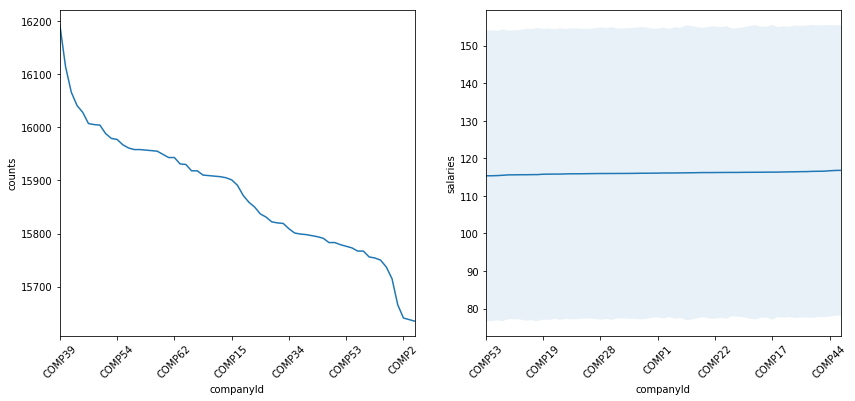

In [31]:
plot_feature(train_df, 'companyId')

There is a very weak correlation between salary and companyId. And variation in distribution is low, maximum is about 16200 and minimum is about15600.

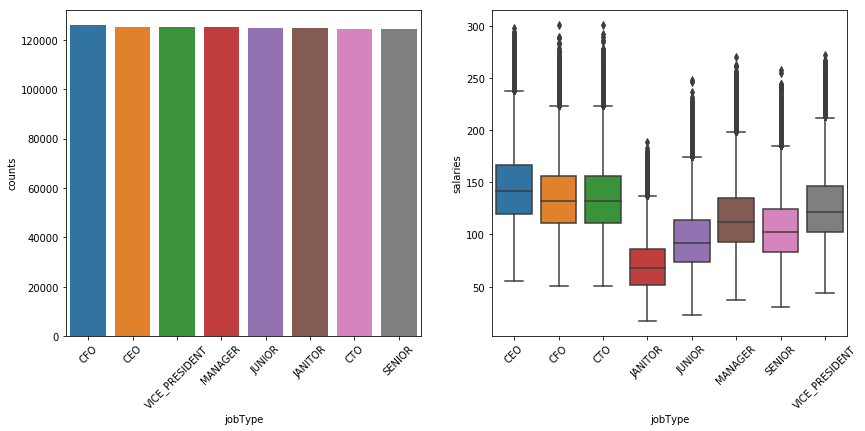

In [32]:
plot_feature(train_df, 'jobType')

There is a moderaate association between job type and salary, the more senior the role the more is salary. Also our sample has almost the same number of each role.

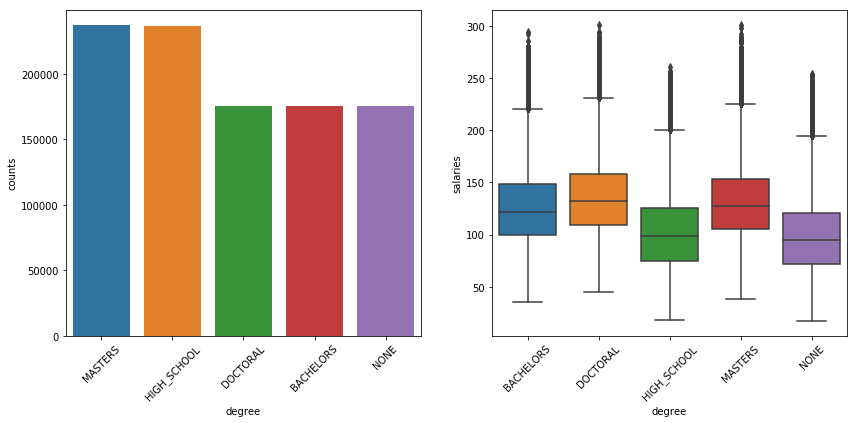

In [7]:
plot_feature(train_df, 'degree')

Salary is weakly correlated with degree, tertiary education has a positive impact on salary. Moreover, there are more employees with masters degree or high school than other subcategories.

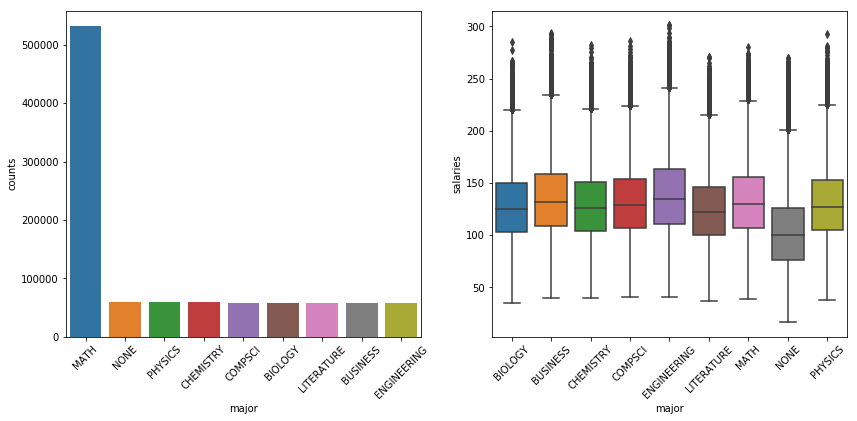

In [8]:
plot_feature(train_df, 'major')

There is a weak correlation between major and salary, the only point is that people with no major (that is no tertiary education) are paid less that other subcategories. Moreover, mathematics graduates occupy significantly more positions compered to the other majors.

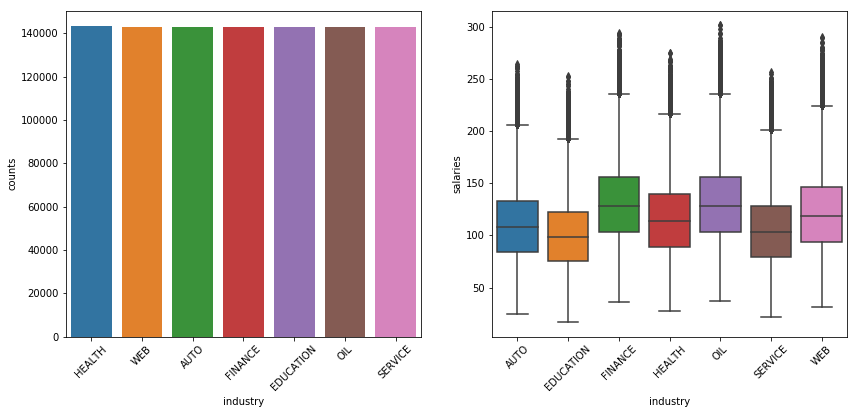

In [9]:
plot_feature(train_df, 'industry')

A weak correlation can be seen between industry and salary. Also, there is almost the same number of jobs in each industry in our dataset.

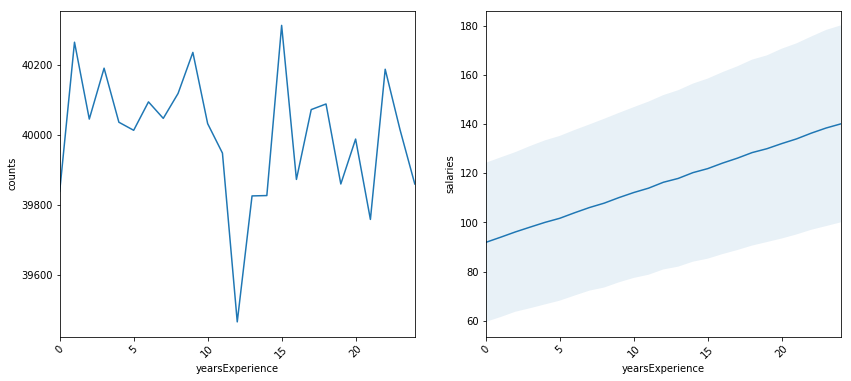

In [10]:
plot_feature(train_df, 'yearsExperience')

There is a weak positive correlation between years of experience and salary.

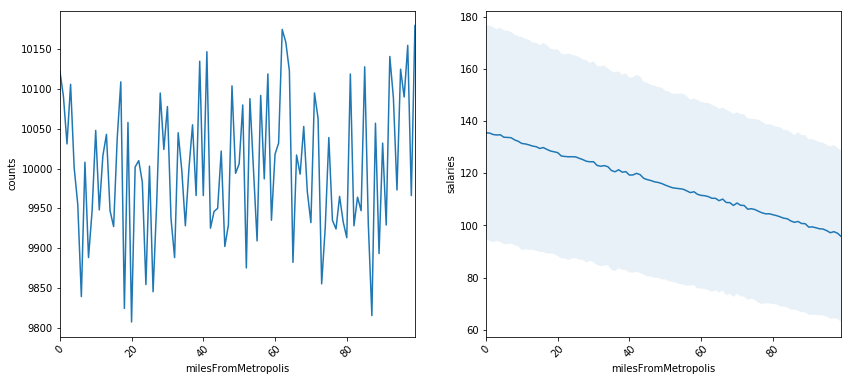

In [11]:
plot_feature(train_df, 'milesFromMetropolis')

There is a clear negative correlation between distance from metropolis and salary.

#### 2-3-3 Looking for correlation between features 

The following function applies to each column of the dataframe and encodes its subcategories with the mean of salary in that subcategory.

In [12]:
def encode_label(df, col):
    cat_dict = {}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col] == cat]['salary'].mean()
    df[col] = df[col].map(cat_dict)

In [13]:
# creating a copy of train_df to label for analysis purposes
corr_df=train_df.copy()

In [14]:
# applying the encode_label function on categorical data
for col in corr_df.columns:
    if corr_df[col].dtype.name == 'category':
         encode_label(corr_df, col)

Text(0.5, 1.0, 'Heatmap of the Correlation Matrix')

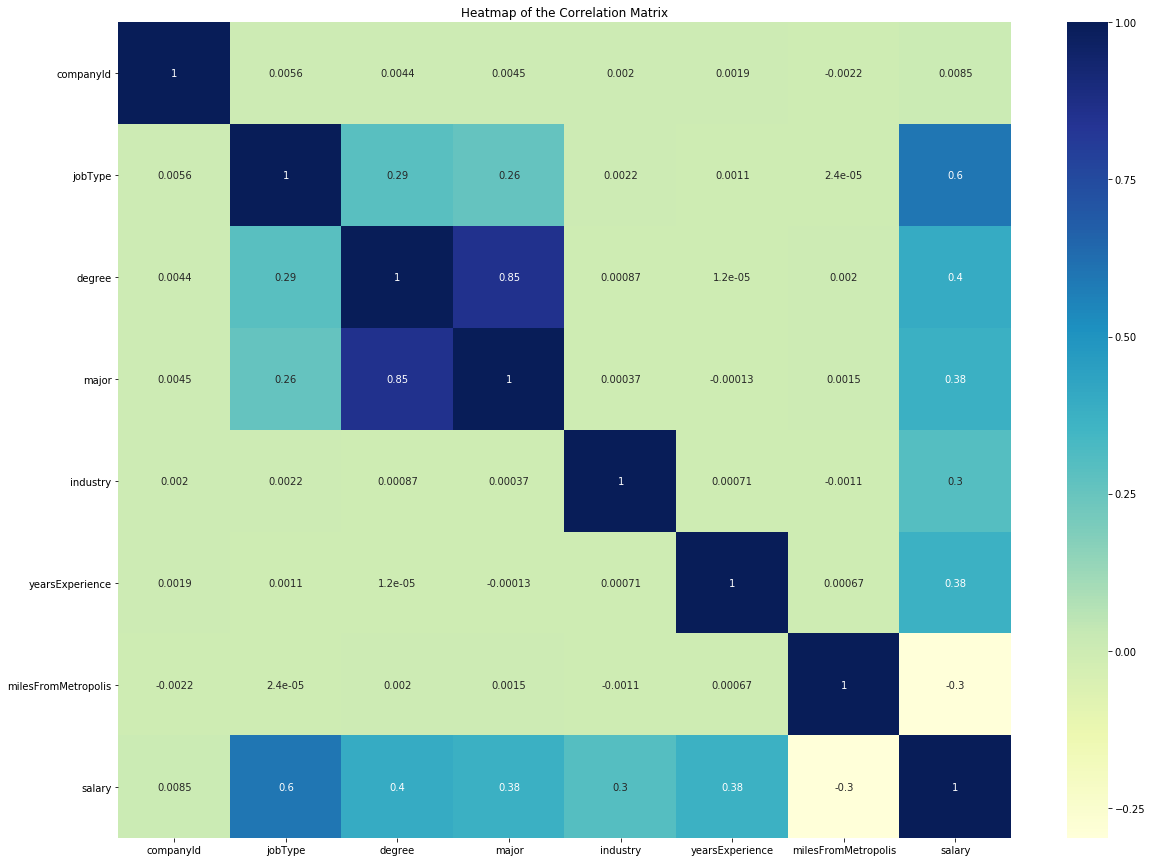

In [12]:
# creating a heatmap of correlations between features and target 
corr = corr_df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap='YlGnBu')


plt.title('Heatmap of the Correlation Matrix')


The correlation between features and salary is clear in coloring. Moreover, there is a strong correlation between major and degree.

#### 2-3-4 Checking the  outliers

In [19]:
stat = train_df['salary'].describe()
print(stat)
IQR= stat['75%']-stat['25%']
upper = stat['75%']+1.5*IQR
lower = stat['25%']-1.5*IQR
print('The upper and lower bount for possible outliers are {} and {}.'.format(upper, lower))

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64
The upper and lower bount for possible outliers are 220.5 and 8.5.


In [20]:
# checking the lower outliers
train_df[train_df['salary']<= 8.5].sum()

jobId                  0.0
companyId              0.0
jobType                0.0
degree                 0.0
major                  0.0
industry               0.0
yearsExperience        0.0
milesFromMetropolis    0.0
salary                 0.0
dtype: float64

In [21]:
# checking the upper outliers
train_df.loc[train_df.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [54]:
# further examining the most suspicious outliers
train_df.loc[(train_df.salary > 220.5) & (train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


Nothing unusual can be detected, so we keep everything as it is.

### 2-4  Establishing a baseline

To establish a baseline, we use the mean salary based on "jobType" subcategories as our prediction algorithm and then measure the result using MSE as metric. The reason to chose job type is that it has the strongest correlation with salary and the distribution of jobs under subcategories is very even.

In [7]:
# This function predicts salary based on subcategories of a given categorical feature
def mean_based_salary_predictor(df, col):
    cat_dict = {}
    predicted_salary = []
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col] == cat]['salary'].mean()
    predicted_salary = df[col].map(cat_dict)
    return predicted_salary

In [8]:
# We apply the function on job type and calculate the score
baseline_model = mse(train_df['salary'], mean_based_salary_predictor(train_df, 'jobType'))
print('baseline_model =',baseline_model )

baseline_model = 963.9252996562975


Our aim in the next section is to improve this score

# Part 3: Develop

 ### 3-1 Feature Engineering

The first step is making data ready for modeling. This requires getting categorical data one-hot-encoded.

In [6]:
def one_hot_encode_data (df, cat_vars = None, num_vars = None):
    ''' This function one-hot-encodes all the categorical features and combines them with numerical ones'''
    cat_df = pd.get_dummies(df[['jobType','major','degree','industry']], drop_first=True)
    num_df = df[['yearsExperience','milesFromMetropolis', 'salary']].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis = 1, ignore_index = False)

In [16]:
modeling_df = one_hot_encode_data (train_df, cat_vars = None, num_vars = None)

### 3-2 Creating Models

The next step is defining algorithms we want to use for predicting salary and tuning them. The tuning part has been omitted here, however, the selected parameters are the result of a tuning process, that is a process of fiddling with parameters to get the desirable result while avoiding over-fitting or under-fitting. For instance, maximum features considered in random forest and gradient boosting regressors need to be kept low to avoid over fitting. Also standard scaling data for linear regression has been tried and does not make a difference, so we put it aside.

In [8]:
lr = LinearRegression ()
rfreg = rfr(random_state=0, n_estimators=75, max_depth=25, criterion='mse', min_samples_split=60, max_features=10)
gbreg = gbr(random_state=0, criterion='mse', min_samples_split=2, max_depth=8, min_samples_leaf=5, subsample=0.8)

### 3-3 Testing Models

In this step we are going to test the tuned algorithms by using 5-fold Cross Validation method. The metric of scoring metric, of course, is our baseline scoring, that is MSE. 

In [9]:
def training_models (algorithm, features, target, results_mean, results_std):
    ''' This function cross validates models and calculates the mean and the std of the five validations'''
    scores_for_model = cvs(algorithm, features, target, cv = 5, scoring = 'neg_mean_squared_error')
    results_mean[algorithm] = -1.0*np.mean(scores_for_model)
    results_std[algorithm] = np.std(scores_for_model)

In [10]:
def print_results (algorithm, results_mean, results_std):
    ''' This function prints the name of the algorithm, the average MSE, and the std for each trained model'''
    print('\nModel:\n', algorithm)
    print('Average MSE:\n', results_mean[algorithm])
    print('Standard Deviation in Modeling Process: \n', results_std[algorithm])

In [20]:
def save_results (algorithm, results_mean, predictions, feature_importances):
    with open('model.txt', 'w') as file:
        file.write(str(algorithm))
    feature_importances.to_csv('feature_importances.csv')
    np.savetxt('predictions.csv', predictions, delimiter = ',')

Now we apply the function on all the selected algorithms

In [14]:
algorithms = [lr, rfreg, gbreg]
results_mean = {}
results_std = {}
for algorithm in algorithms:
    training_models (algorithm, modeling_df[['jobType_CFO', 'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 
                      'jobType_MANAGER', 'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'major_BUSINESS', 
                      'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
                      'major_NONE', 'major_PHYSICS','degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
                      'degree_NONE', 'industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH', 'industry_OIL', 
                      'industry_SERVICE', 'industry_WEB', 'yearsExperience', 'milesFromMetropolis']], 
                     modeling_df['salary'], results_mean, results_std)
    print_results (algorithm, results_mean, results_std)


Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 384.414337322381
Standard Deviation in Modeling Process: 
 1.7820179308288653

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=75, n_jobs=None, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
Average MSE:
 365.63651126508205
Standard Deviation in Modeling Process: 
 1.5830156843952865

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.

### 3-4 Preparing the test dataset and fitting the selected model to it

In [18]:
def one_hot_encode_features (df, cat_vars = None, num_vars = None):
    ''' This function one-hot-encodes all the categorical features and combines them with numerical ones'''
    cat_df = pd.get_dummies(df[['jobType','major','degree','industry']], drop_first=True)
    num_df = df[['yearsExperience','milesFromMetropolis']].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis = 1, ignore_index = False)

test_df = one_hot_encode_features (test_features, cat_vars = None, num_vars = None)

In [19]:
#selecting the algorithm with minimum average MSE
algorithm = min(results_mean, key = results_mean.get)
print ('\nPredictions calculated using model with lowest MSE:')
print (algorithm)

#fitting the selected algorithm to the entire of the train dataset
algorithm.fit(modeling_df[['jobType_CFO', 'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 
                      'jobType_MANAGER', 'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'major_BUSINESS', 
                      'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
                      'major_NONE', 'major_PHYSICS','degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
                      'degree_NONE', 'industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH', 'industry_OIL', 
                      'industry_SERVICE', 'industry_WEB', 'yearsExperience', 'milesFromMetropolis']],
          modeling_df['salary'])

#getting the trained model to predict salary for the test dataset
predictions = algorithm.predict(test_df)


Predictions calculated using model with lowest MSE:
GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [21]:
#extracting and saving feature importance
if hasattr(algorithm, 'feature_importances_'):
    importances = algorithm.feature_importances_
else:
    #Linear algorithm does not have feature_importances_
    importances = [0]*len(features.columns)
    
feature_importances = pd.DataFrame({'feature':test_df.columns,'importance':importances})

feature_importances.sort_values(by = 'importance', ascending = False, inplace = True )
#setting index for 'feature'
feature_importances.set_index('feature', inplace = True, drop = True)

#saving results
save_results (algorithm, results_mean[algorithm], predictions, feature_importances)

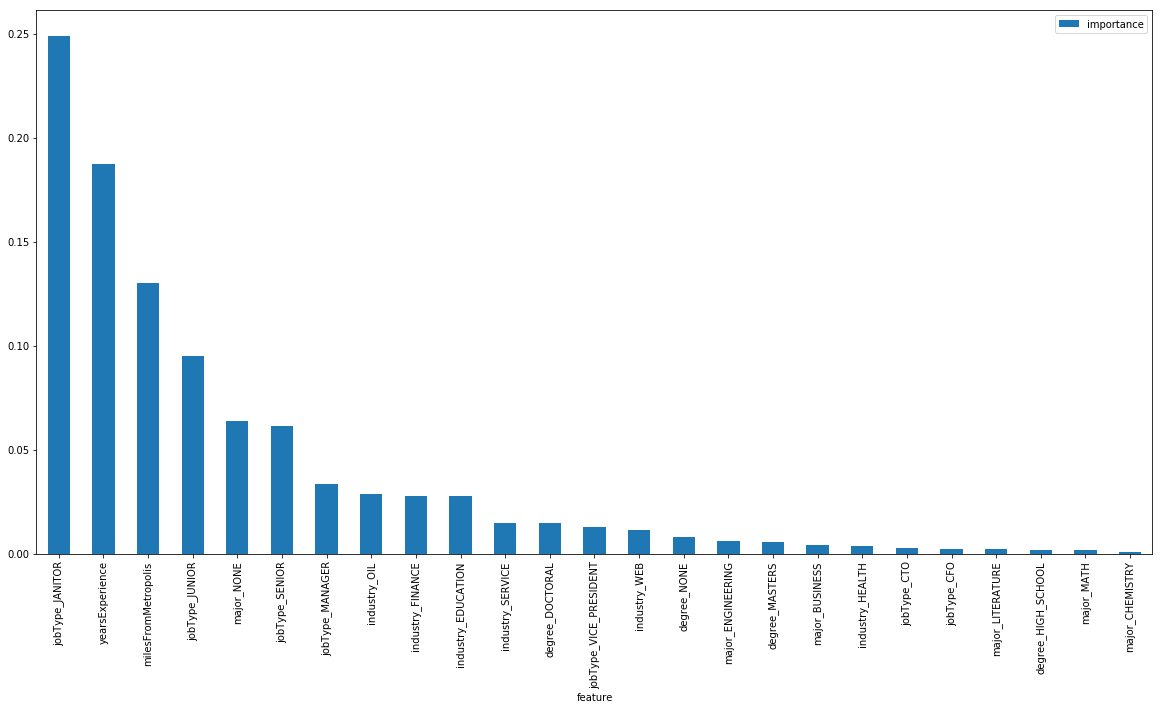

In [22]:
#plotting feature importance
feature_importances[0:25].plot.bar(figsize = (20,10))
plt.show()

Since RandomForestRegressor performs way quicker than GradientBoostingRegressor, we might prefer RandomForestRegressor. Also as can be seen in the following bar chrt, its feature importance looks more reasonable.

In [27]:
rfreg.fit(modeling_df[['jobType_CFO', 'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 
                      'jobType_MANAGER', 'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'major_BUSINESS', 
                      'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
                      'major_NONE', 'major_PHYSICS','degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
                      'degree_NONE', 'industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH', 'industry_OIL', 
                      'industry_SERVICE', 'industry_WEB', 'yearsExperience', 'milesFromMetropolis']],
          modeling_df['salary'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=75, n_jobs=None, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

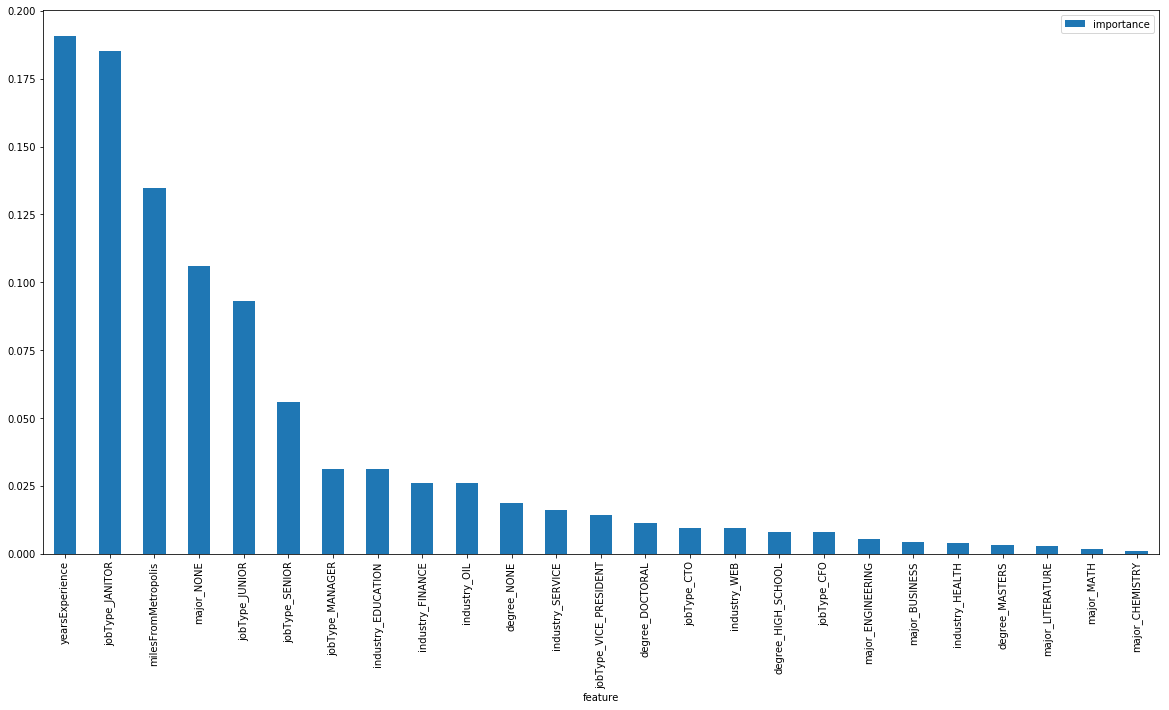

In [25]:
rf_importances = rfreg.feature_importances_

rf_feature_importances = pd.DataFrame({'feature':test_df.columns,'importance':rf_importances})

rf_feature_importances.sort_values(by = 'importance', ascending = False, inplace = True )

rf_feature_importances.set_index('feature', inplace = True, drop = True)

rf_feature_importances[0:25].plot.bar(figsize = (20,10))
plt.show()